# Expanding on Ito et al. (2017) to recover simulated task activity and connectivity matrix


Set up environment

In [1]:
import copy
import sys
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
import pandas as pd
import seaborn as sns
sns.set_style("white")
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA

Import custom modules

In [3]:
sys.path.append('../')
sys.path.append('../../utils/')

# Primary module with most model functions
import model

# Module for FC regression
import multregressionconnectivity as mreg

Helper functions

In [4]:
phi = lambda x: np.tanh(x)

def check_symmetric(a, rtol=1e-05, atol=1e-08):
    return np.allclose(a, a.T, rtol=rtol, atol=atol)

def pshift(y,p):
    y_lag = np.roll(y, p)
    y_lag[:p] = 0
    return y_lag


## Neural network level

In this notebook we expand on simulations described in [Ito et al. (2017)](https://www.nature.com/articles/s41467-017-01000-w.pdf). Ito et al. propose a dynamic neural network model to simulate resting state and task data. Accordingly change in activity in each node is a function of the local connectivity determined by $s$, global connectivity determined by $g$ and task activity for that node described in $I$

\begin{equation*}
\frac{dx_i}{dt}\tau_i = -x_i(t) + s\phi\big(x_i(t)\big) + g\Bigg(\sum_{j\neq i}^{N} W_{ij}\phi\big(x_j(t)\big)\Bigg) + I_i(t)
\end{equation*}


where transformation function $\phi$ is
\begin{equation*}
\phi(x) = \tanh(x) = \frac{\sinh(x)}{\cosh(x)} = \frac{e^{2x}-1}{e^{2x}+1}
\end{equation*}

This transformation is intended to introduce *"a nonlinearity to the interactions among units that is
similar to aggregate nonlinearity from neuronal action potentials"* as explained in [Cole et al. (2016)](https://www.nature.com/articles/nn.4406.pdf). The effect of this transformation can be seen below in the attenuated signal of the transformed timeseries.

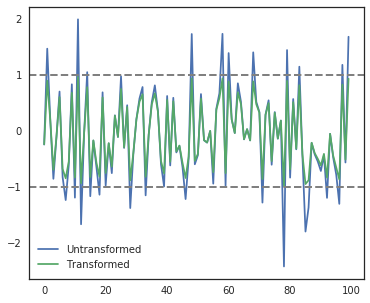

In [5]:
plt.rcParams["figure.figsize"][0] = 6
plt.rcParams["figure.figsize"][1] = 5
a = np.random.normal(size=100)
pa = phi(a)
plt.plot(a, label="Untransformed")
plt.plot(pa, label="Transformed")
plt.axhline(y=1,linewidth=2, color='gray', ls = "--")
plt.axhline(y=-1,linewidth=2, color='gray', ls = "--")
plt.legend()

For simplicity $\tau_i$, $s$ and $g$ are set to 1. The equation can then be rewritten as:

\begin{equation*}
x_i(t) + \frac{dx_i}{dt} = \phi\big(x_i(t)\big) + \sum_{j\neq i}^{N} W_{ij}\phi\big(x_j(t)\big) + I_i(t)
\end{equation*}

\begin{equation*}
x_i(t+1) = \phi\big(x_i(t)\big) + \sum_{j\neq i}^{N} W_{ij}\phi\big(x_j(t)\big) + I_i(t)
\end{equation*}

\begin{equation*}
x_i(t+1) = \phi\big(x_i(t)\big) + w_{i1}\phi\big(x_1(t)\big) + w_{i2}\phi\big(x_2(t)\big) ... + w_{iN}\phi\big(x_N(t)\big) + I_i(t)
\end{equation*}

\begin{equation*}
x_i(t+1) = \beta_{1}\phi\big(x_i(t)\big) + \beta_{2}\phi\big(x_1(t)\big) + \beta_{3}\phi\big(x_2(t)\big) ... + \beta_{N+1}\phi\big(x_N(t)\big) + \beta_{N+2}I_i(t)
\end{equation*}

***Create structural and synaptic network***

One hub and two local networks

In [6]:
# Parameters for subject's networks
ncommunities = 3
innetwork_dsity = .60
outnetwork_dsity = .08
hubnetwork_dsity = .25

nodespercommunity = 35
totalnodes = nodespercommunity*ncommunities

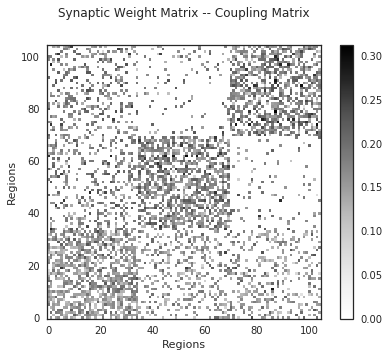

In [7]:
# Construct structural matrix
W = model.generateStructuralNetwork(ncommunities=ncommunities,
                                    innetwork_dsity=innetwork_dsity,
                                    outnetwork_dsity=outnetwork_dsity,
                                    hubnetwork_dsity=hubnetwork_dsity,
                                    nodespercommunity=nodespercommunity,
                                    showplot=False)
# Construct synaptic matrix
G = model.generateSynapticNetwork(W, showplot=True)

Note in this matrix:

`G[from, to]` : efferent connections  
`G[to, from]` : afferent connections  

### Rest activity

***Simulate resting state activity***

Apply neural network model **(Eq 3 in paper)** to the connectivity matrix and calculate each nodes' activity for each time point


**Note that this is still in synaptic space (i.e. not convolved)**

In [8]:
## Set up simulation parameters
#Tmaxrest = 60000 # 1min resting state data
Tmaxrest = 300000 # 5min resting state data
dt = 1.0
tau = 1.0
g = 1.0
s = 1.0

When generating `restdata` the `noise` argument is not set to `None` because change in activity is defined as `spont_act = (noise[:,t] + I[:,t])`. When there is no task defined in `I` if `noise` is set to `None` then there is no activity. Thus `restdata` is conceived of as just noise.

In [ ]:
restdata = model.networkModel(G, 
                              Tmax=Tmaxrest,
                              dt=dt,
                              g=g,
                              s=s,
                              tau=tau,
                              I=None,
                              noise = 1)

In [ ]:
plt.figure()
plt.imshow(restdata, aspect='auto',origin='lower')
plt.title('Simulated resting-state activity', y=1.04, fontsize=16)
plt.ylabel('Regions',fontsize=14)
plt.xlabel('Time (s)',fontsize=14)
plt.colorbar()

### Task activity 

- How do you decide the task's spatial specificity, i.e. which network and nodes within a network it affects primarily? 
    - In the simulations the approach is: For topdown tasks only the hub network is simulated. E.g. for task 1 the first quarter of nodes are stimulated, for task 2 the next quarter etc. 
    - For topdown and bottom up (where a bug was fixed) it is a bit more complicated. E.g. for task 5 the first quarter of the hub network and the nodes of network 1 (first local network) that connect to the hub network (network 0) are stimulated

***Hub network stimulation***

In [ ]:
Ci = np.repeat(np.arange(ncommunities),nodespercommunity) # Construct a community affiliation vector
hub_ind = np.where(Ci==0)[0] # Identify the regions associated with the hub network (hub network is by default the 0th network)

# Set number of time points for each task
#Tmax = 10000
Tmax = 300000 #increased to 5 minutes

T = np.arange(0,Tmax,dt)

taskdata = {}
stimtimes = {}
    
# Construct timing array for convolution -- this timing is irrespective of the task being performed
# Tasks are only determined by which nodes are stimulated
tasktiming = np.zeros((1,len(T)))
for t in range(len(T)):
    if t%2000>500 and t%2000<1000:
    #if t>0 and t%1000==0: #Changed to a task with spikes as activity
        tasktiming[0,t] = 1.0

In [ ]:
topdown_only = range(1,2)
task = 1

taskcount = task-np.min(topdown_only)
stimsize = np.floor(nodespercommunity/4.0)
stim_nodes = np.arange((taskcount)*stimsize,(taskcount)*stimsize+stimsize,dtype=int)
stimtimes[task] = np.zeros((totalnodes,len(T)))

for t in range(len(T)):
    if tasktiming[0,t] == 1:
        # Task stimulation every 10 seconds for 4 seconds, excluding the first 10 seconds
        # Changed to spike every second for 10 minues
        stimtimes[task][stim_nodes,t] = .5

Block design looks like:

In [ ]:
plt.plot(T[:10000], tasktiming[0,:10000])
plt.ylim(top = 1.2, bottom = -0.1)

Activated nodes in the hub network *only* (making it a top-down task) are:

In [ ]:
stim_nodes

Does **NOT** directly use restdata generated above. It uses the **weight matrix G**

In [ ]:
taskdata[task] = model.networkModel(G,Tmax=Tmax,dt=dt,g=g,s=s,tau=tau,
                                          I=stimtimes[task], noise=1)

In [ ]:
plt.figure()
plt.imshow(taskdata[task], aspect='auto',origin='lower')
plt.title('Simulated single topdown task activity', y=1.04, fontsize=16)
plt.ylabel('Regions',fontsize=14)
plt.xlabel('Time (s)',fontsize=14)
plt.xticks(np.arange(0,Tmax+1,10000),np.arange(0,Tmax+1,10000)/100)
plt.colorbar()

## Extending GLM to recover true task activity and connectivity matrix

Using first third of the data for speed of estimation

In [ ]:
taskdata_short = copy.copy(taskdata[1][:,:10000])

In [ ]:
x = copy.copy(stimtimes[task][0,:10000].T)
y = copy.copy(taskdata_short)

In [ ]:
def recover_pars(x, y, p = 1):
        
    ntimepoints = y.shape[1]
    nregions = y.shape[0]
    
    #Initialize empty variables
    task_glm = np.zeros((nregions))
    cur_node_ext_ucr = np.zeros((nregions)) 
    weight_matrix_ext_ucr = np.zeros((nregions, nregions-1))
    task_ext_ucr = np.zeros((nregions))
    cur_node_ext_arc = np.zeros((nregions))
    weight_matrix_ext_arc = np.zeros((nregions, nregions-1))
    task_ext_arc = np.zeros((nregions))
    cur_node_ext_pw = np.zeros((nregions))
    weight_matrix_ext_pw = np.zeros((nregions, nregions-1))
    task_ext_pw = np.zeros((nregions))

    #design matrix/task regressor
    task_reg = copy.copy(x)
    
    for region in range(0, nregions):
    
    #STANDARD GLM  
        cur_y = y[region,:]
        mod_glm = sm.OLS(cur_y, task_reg)
        res_glm = mod_glm.fit()
        task_glm[region] = res_glm.params[0]
        
    #EXTENDED GLM
    #UCR pars
        
        # New y: Shift time course up and drop last time point to model activity in next time step
        cur_yp1 = np.roll(cur_y, -1)[:-1]
        
        # Make design matrix
        # Add current nodes activity in current time step dropping last time step
        cur_node = cur_y[:-1].reshape(-1,1)
        cur_node_t = np.apply_along_axis(phi, 0, cur_node)
        
        # Add other nodes' activity in current time step dropping last time step
        drop_region = [region]
        other_nodes = np.delete(y, drop_region, axis=0)
        other_nodes = other_nodes[:,:-1]
        other_nodes = other_nodes.T
        other_nodes_t = np.apply_along_axis(phi, 0, other_nodes)
        
        ucr_des_mat = np.concatenate((cur_node_t, other_nodes_t), 1)
        
        # Add task activity in current time step
        ucr_des_mat = np.concatenate((ucr_des_mat, task_reg[:-1].reshape(-1,1)), 1)
        
        #Run model and extract parameters
        mod_ext_ucr = sm.OLS(cur_yp1, ucr_des_mat)
        res_ext_ucr = mod_ext_ucr.fit()
        cur_node_ext_ucr[region] = res_ext_ucr.params[0]
        weight_matrix_ext_ucr[region,:] = res_ext_ucr.params[1:-1]
        task_ext_ucr[region] = res_ext_ucr.params[-1]
    
    #ARC pars
        # Add untransformed activity in current node for current time step
        arc_des_mat = np.concatenate((ucr_des_mat, cur_node), 1)
        
        # Add transformed activity in current node from previous time step
        cur_node_m1 = np.roll(cur_node, 1)
        cur_node_m1[0] = 0
        cur_node_m1_t = np.apply_along_axis(phi, 0, cur_node_m1)
        arc_des_mat = np.concatenate((arc_des_mat, cur_node_m1_t), 1)
        
        # Add transformed activity from other nodes from previous time step
        other_nodes_m1 = np.roll(other_nodes, 1, axis=0)
        other_nodes_m1[0] = 0
        other_nodes_m1_t = np.apply_along_axis(phi, 0, other_nodes_m1)
        arc_des_mat = np.concatenate((arc_des_mat, other_nodes_m1_t), 1)
        
        # Add task activity from previous time step
        task_reg_m1 = np.roll(task_reg[:-1], 1)
        task_reg_m1[0] = 0
        task_reg_m1 = task_reg_m1.reshape(-1,1)
        
        arc_des_mat = np.concatenate((arc_des_mat, task_reg_m1), 1)
        
        #Run model and extract parameters
        mod_ext_arc = sm.OLS(cur_yp1, arc_des_mat)
        res_ext_arc = mod_ext_arc.fit()
        cur_node_ext_arc[region] = res_ext_arc.params[0]
        weight_matrix_ext_arc[region,:] = res_ext_arc.params[1:nregions]
        task_ext_arc[region] = res_ext_arc.params[nregions]
        
    #PW pars
    
        # Extract errors from res_ext_ucr
        err_ext_ucr = res_ext_ucr.resid
        
        # Run AR(p) model on residuals
        try:
            ar_mod = ARMA(err_ext_ucr, order=(p, 0))
            ar_res = ar_mod.fit(trend="nc")
            ar_est = ar_res.params
            
        # Prewhiten cur_yp1 and ucr_des_mat
            shift_y = pshift(cur_yp1, p)
            shift_X = pshift(ucr_des_mat, p)
            mpw_y = cur_yp1 - (ar_est*shift_y)
            mpw_X = ucr_des_mat - (ar_est*shift_X)
            mod_ext_pw = sm.OLS(mpw_y, mpw_X)
            res_ext_pw = mod_ext_pw.fit()
            cur_node_ext_pw[region] = res_ext_pw.params[0]
            weight_matrix_ext_pw[region,:] = res_ext_pw.params[1:-1]
            task_ext_pw[region] = res_ext_pw.params[-1]
        
        except:
            print('Whitening failed!')
            cur_node_ext_pw[region] = np.nan
            weight_matrix_ext_pw[region:] = np.nan
            task_ext_pw[region] = np.nan
            ar_est = np.nan
    
    
    out = {'task_glm':task_glm,
           'cur_node_ext_ucr':cur_node_ext_ucr,
           'weight_matrix_ext_ucr':weight_matrix_ext_ucr,
           'task_ext_ucr': task_ext_ucr,
           'cur_node_ext_arc':cur_node_ext_arc,
           'weight_matrix_ext_arc':weight_matrix_ext_arc,
           'task_ext_arc':task_ext_arc,
           'cur_node_ext_pw':cur_node_ext_pw,
           'weight_matrix_ext_pw':weight_matrix_ext_pw,
           'task_ext_pw':task_ext_pw,
           'ar_est': ar_est}
    
    return (out)

In [ ]:
out = recover_pars(x, y)

#### Task betas reduced after correction?


In [ ]:
task_betas = pd.DataFrame(data = {'task_glm': out['task_glm'],
                         'task_ext_ucr': out['task_ext_ucr'],
                         'task_ext_arc': out['task_ext_arc'],
                         'task_ext_pw': out['task_ext_pw']})

In [ ]:
plt.rcParams["figure.figsize"][0] = 8
plt.rcParams["figure.figsize"][1] = 6
plt.plot(task_betas['task_glm'], color = "blue", label = "Classic GLM")
plt.plot(task_betas['task_ext_ucr'], color = "green", label = "Extended GLM no ARC")
plt.plot(task_betas['task_ext_arc'], color = "red", label = "Extended GLM ARC")
plt.plot(task_betas['task_ext_pw'], color = "purple",label = "Extended GLM PW")
plt.ylabel('Beta',fontsize=14)
plt.xlabel('Node',fontsize=14)
plt.axhline(y=.5,linewidth=2, color='gray', ls = "--")
plt.axhline(y=0,linewidth=2, color='gray', ls = "--")
plt.axvline(x=35,linewidth=2, color='gray', ls = "--")
plt.axvline(x=70,linewidth=2, color='gray', ls = "--")
plt.legend(loc="best")

#### Current node betas == 1?

In [ ]:
cur_node_betas = pd.DataFrame(data = {'cur_node_ext_ucr': out['cur_node_ext_ucr'],
                         'cur_node_ext_arc': out['cur_node_ext_arc'],
                         'cur_node_ext_pw': out['cur_node_ext_pw']})

In [ ]:
plt.rcParams["figure.figsize"][0] = 8
plt.rcParams["figure.figsize"][1] = 6
plt.plot(cur_node_betas['cur_node_ext_ucr'], color = "green",label = "Extended GLM no ARC")
plt.plot(cur_node_betas['cur_node_ext_arc'], color = "red",label = "Extended GLM ARC")
plt.plot(cur_node_betas['cur_node_ext_pw'], color = "purple",label = "Extended GLM PW")
plt.ylabel('Beta',fontsize=14)
plt.xlabel('Node',fontsize=14)
plt.axhline(y=1,linewidth=2, color='gray', ls = "--")
plt.axvline(x=35,linewidth=2, color='gray', ls = "--")
plt.axvline(x=70,linewidth=2, color='gray', ls = "--")
plt.legend(loc="best")

#### Other node betas recapitulate connectivity matrix?

**Relationship between other nodes betas and the afferent connectivity weights (can you recover the connectivity matrix?)**

In [ ]:
nregions = y.shape[0]
weight_matrix_betas_ucr = np.zeros((nregions,nregions))
weight_matrix_betas_arc = np.zeros((nregions,nregions))
weight_matrix_betas_pw = np.zeros((nregions,nregions)) 
for i in range(nregions):
    weight_matrix_betas_ucr[i] = np.insert(out['weight_matrix_ext_ucr'][i],i,0)
    weight_matrix_betas_arc[i] = np.insert(out['weight_matrix_ext_arc'][i],i,0)
    weight_matrix_betas_pw[i] = np.insert(out['weight_matrix_ext_pw'][i],i,0)

In [ ]:
plt.figure()
plt.imshow(weight_matrix_betas_ucr, origin='lower')
plt.colorbar()
plt.title("Coefficients for other nodes' activity", y=1.04, fontsize=16)
plt.xlabel('Regions',fontsize=14)
plt.ylabel('Regions', fontsize=14)
plt.tight_layout()

In [ ]:
plt.figure()
plt.imshow(weight_matrix_betas_arc, origin='lower')
plt.colorbar()
plt.title("Coefficients for other nodes' activity", y=1.04, fontsize=16)
plt.xlabel('Regions',fontsize=14)
plt.ylabel('Regions', fontsize=14)
plt.tight_layout()

In [ ]:
plt.figure()
plt.imshow(weight_matrix_betas_pw, origin='lower')
plt.colorbar()
plt.title("Coefficients for other nodes' activity", y=1.04, fontsize=16)
plt.xlabel('Regions',fontsize=14)
plt.ylabel('Regions', fontsize=14)
plt.tight_layout()